# Chapter 15: Watershed Delineation

[JP Gannon](https://jpgannon.github.io/)
[](https://orcid.org/0000-0002-4595-3214)
([Virginia Tech](https://www.vt.edu/))  
2025-12-11

# Geospatial R Raster - Watershed Delineation

## Introduction

The following activity is available as a template github repository at
the following link:
https://github.com/VT-Hydroinformatics/15-Watershed-Delineation.git

**For more:
https://geocompr.robinlovelace.net/spatial-class.html#raster-data**

**To read in detail about any of the WhiteboxTools used in this
activity, check out the user manual:
https://jblindsay.github.io/wbt_book/intro.html**

**This activity is adapted from/inspired by:
https://matthewrvross.com/active.html and other code from Nate Jones.**

*Goals for this activity:*

*Use R to delineate the watershed for several pour points on a DEM  
*Extract topographic information from those watersheds

Check out the list of packages for this exercise. If you have trouble
getting rayshader or rgl going, don’t fret too much, these are for the
3d watershed visualization at the end that is basically just something
fun to check out.

In [ ]:
library(tidyverse)
library(terra)
library(sf)
library(whitebox)
library(tmap)
library(stars)
library(rayshader)
library(rgl)

whitebox::wbt_init()

knitr::knit_hooks$set(webgl = hook_webgl)

theme_set(theme_classic())

## The watershed delineation tool/process

With watershed delineation, it is helpful to take a step back and think
about how the whole process works before we dive in. The way things are
presented below is pretty linear, but there is no way you would arrive
at it by just trying to fire up the watershed delineation function in
whitebox. It took some planning to figure out this process! So let’s
work through it…

We will use the wbt_watershed() function to delineate our watersheds.
This function looks upslope from a given point or points (the pour
point(s)) and figures out what area drains to that point. To run this
function you need a *D8 pointer grid* and *a pour point, or pour
points*. Sounds simple. But we have to do a few things to generate those
two inputs.

*Generating the D8 pointer grid:* this is a grid where each cell
specifies what direction water will flow out of that cell. So if our DEM
has any pits or depressions without outlets in it, there will be flow
dead-ends. This will result in an incorrect watershed delineation. (This
was covered in the last chapter) So we have to prepare our DEM to get
rid of pits/depressions.

We will do this in two stages. First we will *fill single cell pits* and
then *breach larger depressions*. It is important to remember that for
this to work you have to fill the single cell depressions, then pass the
*resulting DEM* from that process to the breach depression function.
Once you have done this, you can run the D8 pointer function to generate
your pointer grid.

*Making pour points:* The key here is that your pour points MUST….
*MUST* be on one of the cells in the “stream”, according to your DEM. If
it is even one cell over from the high flow accumulation cells that
denote the stream on your DEM, you will just get a weird, small sliver
of a watershed.

The first step is to get the coordinates of your pour point(s). You
could grab them from google earth, use a GPS in the field, or maybe you
have coordinates for a known location/structure that defines your
“outlet”. This could be a flume, weir, gaging station, etc. *AHEM* EVEN
IF your coordinates came from the super fanciest GPS-iest post-processed
differential nanometer accuracy wonder GPS, you STILL need to use the
process described below to be sure they are on your flow network. Your
points might be in the right place, but that doesn’t mean that’s where
the stream is according to your DEM!

You can read your points in as a csv or just define them in your code if
there aren’t many (that’s what we will do) and then turn them into a
spatial object using SpatialPoints(), and then export them as a
shapefile. If you are reading in a shapefile with your points, you don’t
need to convert/export them.

With our points in hand, we then need to make sure they are on our
stream network. To do that we will use Jensen snap pour points function
in wbt. This tool takes your points, searches within a defined area for
the stream network, then moves the points to the stream network. This
function needs your *pour points* and a *raster stream file*. So…. we
need to make the raster stream file! We do this using the extract
streams wbt function. This function takes a D8 flow accumulation grid,
so we need to create that first. Then we can run the stream network
function and the snap pour points function.

*A note on units:* be sure you know what the distance units are in your
data. In our case everything is in decimal degrees, so we need to
specify how far the pour point function will search in degrees. If we
were using UTM data, that number would be in meters, and if we were in
state plane (in VA) that number would be in feet. You can 100% crash R
and send wbt into a death spiral if you mix your units up and send the
snap pour points function off searching for the biggest stream within
10,000 miles.

*SO! Our process will look like this:*  
*Read in DEM  
*Fill single cell sinks then breach breach larger sinks  
*Create D8 flow accumulation and D8 pointer grids  
*Read in pour points  
*Create stream raster  
*Snap pour points to stream raster  
\*Run watershed function  

**There will be some extra steps in there just to aid in visualization,
but if you were just writing code to perform the analysis, the above is
the ticket**

## Read in DEM

The first several steps are review from the previous activity.

First we will read in the raster, set its CRS (not always needed), set
values below 1500 to NA since they are artefacts around the edges, and
plot the DEM to be sure everything went ok.

ℹ tmap modes "plot" - "view"
ℹ toggle with `tmap::ttm()`


── tmap v3 code detected ───────────────────────────────────────────────────────
[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "PuOr" is named
"brewer.pu_or"

work in progress

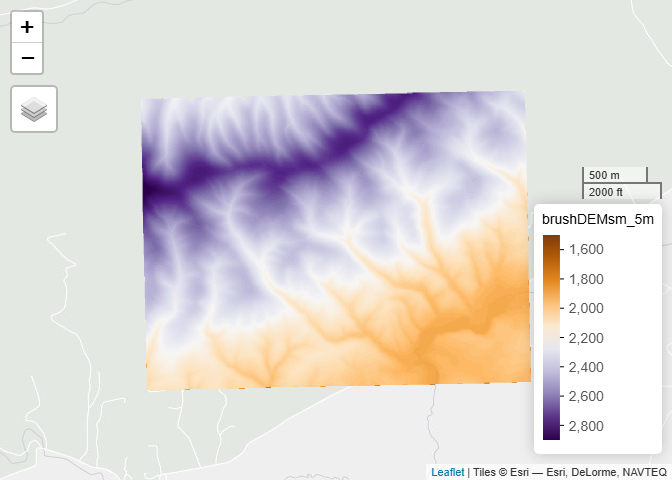

In [ ]:
tmap_mode("view")

## Generate a hillshade

Next, we will generate a hillshade to aid in visualization and then plot
it to be sure it turned out ok.

── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
! `tm_scale_bar()` is deprecated. Please use `tm_scalebar()` instead.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")

work in progress

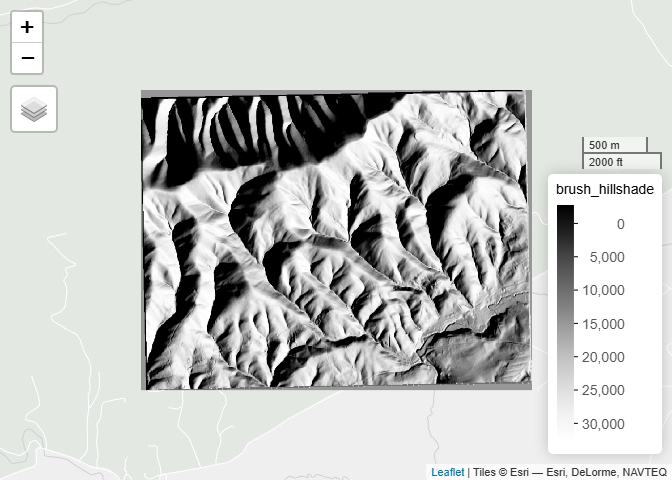

In [ ]:
wbt_hillshade(dem = "McDonaldHollowDEM/brushDEMsm_5m_crs.tif",
              output = "McDonaldHollowDEM/brush_hillshade.tif",
              azimuth = 115)

hillshade <- rast("McDonaldHollowDEM/brush_hillshade.tif")

tm_shape(hillshade)+
  tm_raster(style = "cont",palette = "-Greys", legend.show = FALSE)+
  tm_scale_bar()

## Prepare DEM for Hydrology Analyses

This step is review from last time as well, but it is important to point
out that it is crucial for this analysis. Basically we are looking
upslope for all DEM cells that drain to a specific spot, so if there are
any dead-ends, we will not get an accurate watershed.

In order to be sure all of our terrain drains downlope, we will breach
depressions using the wbt_breach_depressions_least_cost() tool with a
distance of 5 and then fill any remaining depressions with
wbt_fill_depressions_wang_and_liu()

There is a much more in-depth discussion of why we are doing this in the
previous chapter.

From now on in the analysis *be careful* to use the filled and breached
DEM.

In [ ]:
wbt_breach_depressions_least_cost(
  dem = "McDonaldHollowDEM/brushDEMsm_5m_crs.tif",
  output = "McDonaldHollowDEM/bmstationdem_breached.tif",
  dist = 5,
  fill = TRUE)

wbt_fill_depressions_wang_and_liu(
  dem = "McDonaldHollowDEM/bmstationdem_breached.tif",
  output = "McDonaldHollowDEM/bmstationdem_filled_breached.tif"
)

## Create flow accumulation and pointer grids

The watershed delineation process requires a D8 flow accumulation grid
and a D8 pointer file. There were both discussed last chapter. The flow
accumulation grid is a raster where each cell is the area that drains to
that cell, and the pointer file is a raster where each cell has a value
that specifies which direction water would flow downhill away from that
cell.

Below, create these two rasters using the *filled and breached* DEM.

In [ ]:
wbt_d8_flow_accumulation(input = "McDonaldHollowDEM/bmstationdem_filled_breached.tif",
                         output = "McDonaldHollowDEM/D8FA.tif")

wbt_d8_pointer(dem = "McDonaldHollowDEM/bmstationdem_filled_breached.tif",
               output = "McDonaldHollowDEM/D8pointer.tif")

## Setting pour points

The last thing we need is our pour points. These are the point locations
for which we will delineate our watersheds. It is *crucial* that these
points are on the stream network in each watershed. If the points are
even one cell off to the side, you will not get a valid watershed.
Instead you will end up with a tiny sliver that shows the area that
drains to that one spot on the landscape.

Even with highly accurate GPS locations, we still need to check to be
sure our pour points are on the stream network, because the DEM might
not line up perfectly with the points.

Fortunately, there is a wbt function that will make sure our points are
on the stream network. wbt_jenson_snap_pour_points() looks over a
defined distance from the points you pass it for closest stream and then
moves the points to those locations. So to use this function we also
need to create a stream network.

We will follow the following process to get our pour points set up:

> Create dataframe with pour points  
> Convert data frame to shapefile  
> Write the shapefile to our data directory  
> Move points with snap pour points function

Perform the first two operations above in this chunk, the pour points
are given. I just grabbed them from google earth.

In [ ]:
ppoints <- tribble(
          ~Lon, ~Lat,
          -80.482778, 37.240504,
          -80.474464, 37.242990,
          -80.471506, 37.244512
          )

ppointsSP <- st_as_sf(ppoints, coords = c("Lon", "Lat"), crs = 4326)

write_sf(ppointsSP, "McDonaldHollowDEM/pourpoints.shp", overwrite = TRUE)

Now, following the process from last chapter, we will create a raster
stream grid using a threshold flow accumulation of 6000 using the D8
flow accumulation grid.

Then finally, we will use the Jenson snap pour points function to move
the pour points to their correct location.

The parameter snap_dist tells the function what distance in which to
look for a stream. The units of the files we are using are decimal
degrees, so we have to be careful here! Use a value of 0.0005, which is
about 50 meters. If you were to put 50, it would search over 50 degrees
of lat and lon!!! (I did this when making this activity and there was a
lot of crashing)

After you get the streams and snapped pour points, read them into your R
environment and plot them to be sure the pour points are on the streams.

── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_tm_raster()`: migrate the argument(s) related to the scale of the
visual variable `col` namely 'palette' (rename to 'values') to col.scale =
tm_scale(<HERE>).
The visual variable `col` of the layer "raster" contains a unique value.
Therefore a discrete scale is applied (tm_scale_discrete).
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "Blues" is named
"brewer.blues"

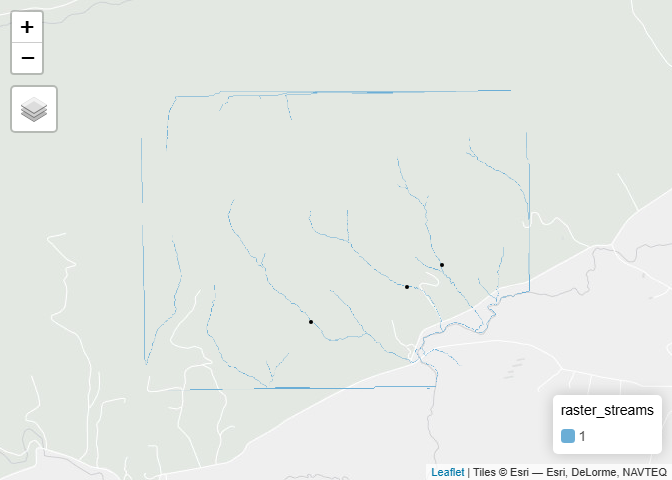

In [ ]:
wbt_extract_streams(flow_accum = "McDonaldHollowDEM/D8FA.tif",
                    output = "McDonaldHollowDEM/raster_streams.tif",
                    threshold = 6000)

wbt_jenson_snap_pour_points(pour_pts = "McDonaldHollowDEM/pourpoints.shp",
                            streams = "McDonaldHollowDEM/raster_streams.tif",
                            output = "McDonaldHollowDEM/snappedpp.shp",
                            snap_dist = 0.0005) #careful with this! Know the units of your data

pp <- read_sf("McDonaldHollowDEM/snappedpp.shp")
streams <- rast("McDonaldHollowDEM/raster_streams.tif")

tm_shape(streams)+
  tm_raster(legend.show = TRUE, palette = "Blues")+
tm_shape(pp)+
  tm_dots(col = "red")

## Delineate watersheds

Now we are all set to delineate our watersheds!

Use wbt_watershed(), which takes as input a D8 pointer file (d8_pntr)
and our snapped pour points (pour_pts). It will output a raster where
each watershed is populated with a unique value and all other cells are
NA.

Read the results of this function back in and plot them over the
hillshade with alpha set to 0.5 to see what it did.

── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
[v3->v4] `tm_raster()`: instead of `style = "cat"`, use col.scale =
`tm_scale_categorical()`.
[v3->v4] `tm_raster()`: use `col_alpha` instead of `alpha`.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")

work in progress

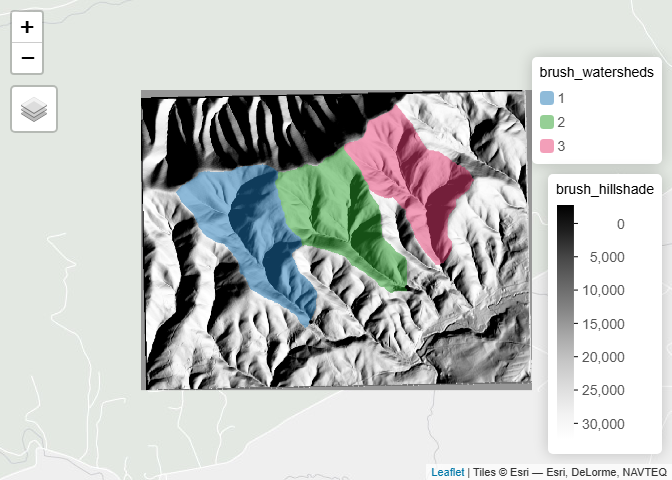

In [ ]:
wbt_watershed(d8_pntr = "McDonaldHollowDEM/D8pointer.tif",
              pour_pts = "McDonaldHollowDEM/snappedpp.shp",
              output = "McDonaldHollowDEM/brush_watersheds.tif")

ws <- rast("McDonaldHollowDEM/brush_watersheds.tif")

tm_shape(hillshade)+
  tm_raster(style = "cont",palette = "-Greys", legend.show = FALSE)+
tm_shape(ws)+
  tm_raster(legend.show = TRUE, alpha = 0.5, style = "cat")+
tm_shape(pp)+
  tm_dots(col = "red")

## Convert watersheds to shapefiles

For mapping or vector analysis it can be very useful to have your
watersheds as polygons. To do this we will use the stars package.
st_as_stars() converts our watershed raster into an object that the
stars package can work with, and then st_as_sf() converts the raster
stars object to a vector sf object. We also need to set merge to TRUE,
which tells st_as_sf to treat each clump of cells with the same value
(our watersheds) as its own feature.

Now we can plot the vector versions of our watersheds, and also use
filter() to just show one at a time, or some combination, rather than
all three.

── tmap v3 code detected ───────────────────────────────────────────────────────

[v3->v4] `tm_raster()`: instead of `style = "cont"`, use col.scale =
`tm_scale_continuous()`.
ℹ Migrate the argument(s) 'palette' (rename to 'values') to
  'tm_scale_continuous(<HERE>)'
[v3->v4] `tm_raster()`: use `col.legend = tm_legend_hide()` instead of
`legend.show = FALSE`.
[cols4all] color palettes: use palettes from the R package cols4all. Run
`cols4all::c4a_gui()` to explore them. The old palette name "-Greys" is named
"greys" (in long format "brewer.greys")

work in progress

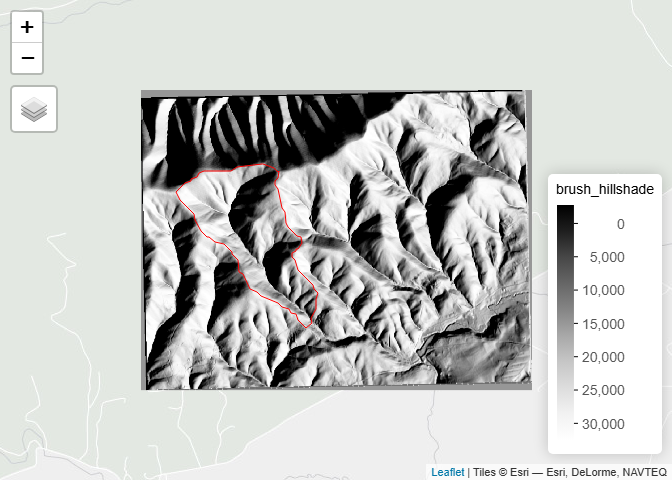

In [ ]:
wsshape <- st_as_stars(ws) %>% st_as_sf(merge = T)

ws1shp <- wsshape %>% filter(brush_watersheds.tif == "1")

tm_shape(hillshade)+
  tm_raster(style = "cont",palette = "-Greys", legend.show = FALSE)+
tm_shape(ws1shp)+
  tm_borders(col = "red")

## Extract data based on watershed outline

Now, just like we looked at the distribution of different landscape data
over an entire DEM in the last chapter, we can look at landscape data
for each watershed. To do this we will use the extract() function to
extract elevation data for just the watershed shapes (vector version).
Then we will grab the data for each watershed, since the output here is
a list, and plot them in separate geoms in ggplot.

Just like in last chapter you could do this for any of the topographic
measures we calculated, including extracting multiple datasets and
comparing them to one another. Cool!

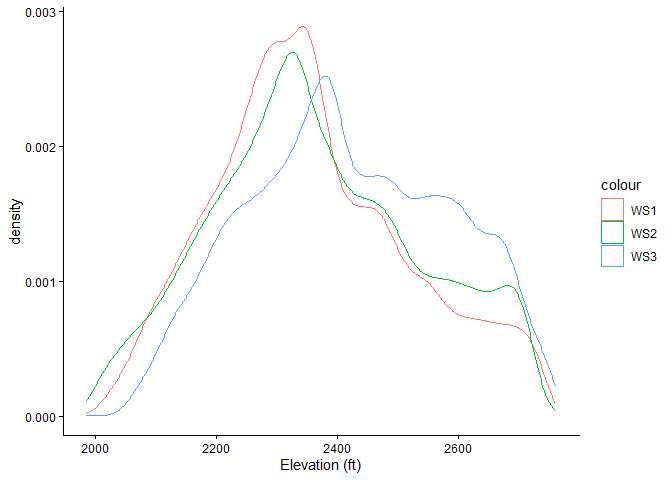

In [ ]:
wsElevs <- extract(dem, wsshape)

WS1 <- wsElevs$brushDEMsm_5m[wsElevs$ID == 1] |> as_tibble()
WS2 <- wsElevs$brushDEMsm_5m[wsElevs$ID == 2] |> as_tibble()
WS3 <- wsElevs$brushDEMsm_5m[wsElevs$ID == 3] |> as_tibble()

ggplot() +
  geom_density(WS1, mapping = aes(value, color = "WS1"))+
  geom_density(WS2, mapping = aes(value, color = "WS2"))+
  geom_density(WS3, mapping = aes(value, color = "WS3"))+
  xlab("Elevation (ft)")

## BONUS: Make a 3d map of your watershed with rayshader

The following code is here just because it is cool. We clip the DEM to
the watershed we want, convert it to a matrix, create a hillshade using
rayshader (a visualization tool for 3d stuff), and then plot the output.

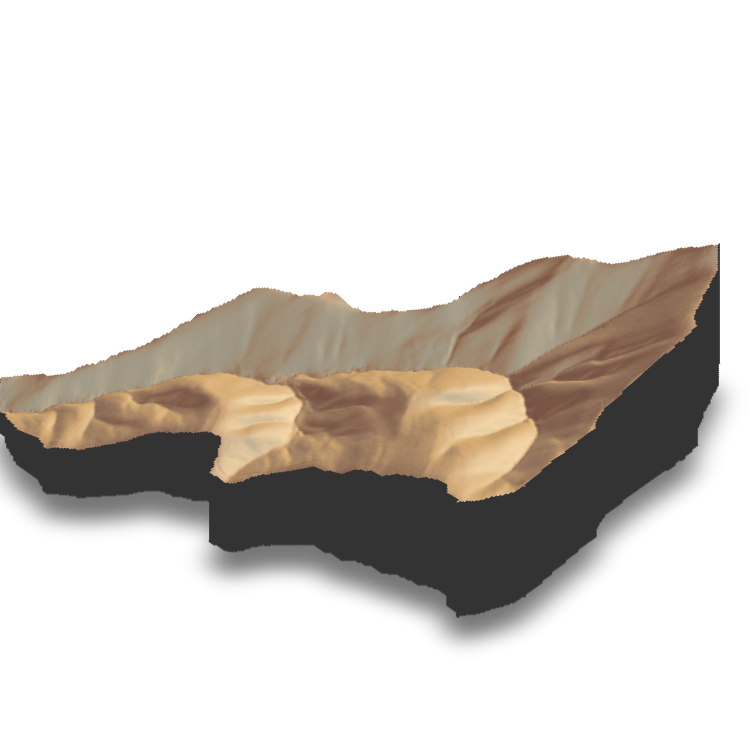

In [ ]:
ws1_bound <- filter(wsshape, brush_watersheds.tif == "1")

#crop
wsmask <- dem %>%
  crop(., ws1_bound) %>%
  mask(., ws1_bound)

#convert to matrix
wsmat <- matrix(
  data = wsmask,
  nrow = ncol(wsmask),
  ncol = nrow(wsmask))

#create hillshade
raymat <- ray_shade(wsmat, sunable = 115)

#render
wsmat %>%
  sphere_shade(texture = "desert") %>%
  plot_3d(wsmat, zscale = 10, fov = 0, theta = 135, zoom = 0.75, phi = 45,
          windowsize = c(750,750))

# Save/display the static image instead of rendering the widget
watershed_3d_plot_fp <- "images/watershed_3d_plot.png"
rgl::rgl.snapshot(watershed_3d_plot_fp)
rgl::close3d()
knitr::include_graphics(watershed_3d_plot_fp)